# CAR ACCIDENTS IN SWITZERLAND

## The Pizzafels

### Notebook for milestone 3

## Introduction

This notebook presents our analysis of the car accidents in Switzerland over the past years. From the different datasets that could be correlated to the accidents that we found online on the Swiss OpenData platform, we wanted to identify the ones with the highest impact, so as to be able to make predictions for the future and advise the government/the cantons on the matter.

### Important prior note

We tried to keep a clean tracking of the data in English, but it would have been a pain to manually rewrite every French - German - Italian - Romansh (yes, it exists) information in Shakespeare's language. This is why you can see some of the Swiss languages sometimes in our data, for example in the names of the dataframes, or their columns. We are sorry for the inconvenient and we commented it in a way that is hopefully sufficiently clear to understand what is going on even if you solely understand English!

### .Imports

In [33]:
import plotly
plotly.tools.set_credentials_file(username='clementg20', api_key='DqIypbzBxQGr32fyKO5R')

In [1]:
import os
import pandas as pd
import json
import numpy as np
import re
import math
import numpy as np
import codecs
import folium
from scipy.stats.stats import pearsonr
from sklearn.preprocessing import normalize
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot



### .Constants

In [2]:
DATA_FOLDER = '../data_clean'
IS_DATE = re.compile("^[1-2]{1}[0-9]{3}$") #will be useful to detect values that correspond to dates

geo_center_ch = [46.8, 8.23] # Alggi-Alp

CANTON_TOPO_PATH = '../ch-cantons.topojson.json'
CANTON_TOPO = json.load(open(CANTON_TOPO_PATH)) #GeoJson file of cantons used in Homework2

PLOT_FOLDER = './test_output/'
DF_FOLDER = './test_output/'
MAP_FOLDER = './test_output/'

### .Useful functions

#### Function to quickly describe a dataframe

In [3]:
def describeDf(df,name="DESCRIPTION",level=2):
    """
    Describe the data. Different levels are possible.
    Level 0: Print the title of the dataset
    Level 1: Name the different columns
    Level 2: Explore the values of each column
    """
    date=[]
    
    # Explore each column of the dataset
    if(level==2):
        # Print a header
        print("______________________________ " + name+" ______________________________\n")
        print("\n")
        for col in df.columns:
            # Print the attributes of each column
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                print("         ATTRIBUTE: "+col)
                print("   "+str(df[col].unique()))
                print("\n")
            else:
                date.append(col)
        # Print the years we have information on
        print("         VALUES: "+str(date))
        print("\n\n\n")
        return
    
    # Recover and print the columns of the datasets
    elif(level==1):
        # Print a header
        print("______________________________ " + name+" ______________________________\n")
        val = []
        # Print the different columns
        for col in df.columns:
            if((not IS_DATE.match(col)) & (not re.compile("[0-9]+ an").match(col))):
                val.append(col)
        print(val)
        print("\n\n\n")
        return
    
    # Simply print the name of the dataset
    elif(level==0):
        print("   >  " + name+"\n")
    
    # Sanity check: the given level does exist
    else:
        raise NotImplementedError

#### Function to restrict the dataframe to a fix period in term of years

We need this function as our different datasets are often based on different yearly periods.

In [4]:
def get_period(df, start=None,end=None):
    """
    Function to keep the columns of interest of a dataset, between a starting and an ending date.
    """
    columns_to_keep = []
    dates = []
    
    # Go through the columns
    for elem in df.columns:
        # If it is not a date we keep it
        if not IS_DATE.match(elem):
            columns_to_keep.append(elem)
        # Else we store it to see later if we keep it
        else:
            dates.append(int(elem))
    
    # Define the starting and ending dates in the case they are not
    if start == None:
        start = np.min(dates)
    if end == None:
        end = np.max(dates)
    
    # Only keep the columns of interest
    for date in dates:
        if (date<=end) & (date>=start):
            columns_to_keep.append(str(date))
    
    return df[columns_to_keep]

#### Function to get the age corresponding to the intervals as input

Using this functions will allow us to treat people between 40 and 50 years old as one group for example. Again, this is needed because of the disparity among the datasets, with some of them considering each age category differently, while others  groupped the people in different intervals. This functions allow us to compare and work with those different datasets.

In [5]:
def map_int_to_age(k,age_max):
    """
    Transform an integer to what is define as an age, i.e. 20 to '20 ans' ('20 years old')
    """
    if(k != 1 and k<age_max):
        return '{} ans'.format(k)
    if(k == 1):
        return '{} an'.format(k)
    if(k==age_max):
        if (age_max == 100):
            return '{} ans ou plus'.format(age_max)
        else:
            return '{} ans et plus'.format(age_max)

In [6]:
def build_age(intervals,age_max):
    """
    INPUT:  intervals: Array corresponding to the delimitation of the wanted intervals.
            age_max: The maximal age to consider.
    """
    ages_total = []
    
    # Build the intervals
    for i in range(len(intervals)-1):
        ages = []
        
        # We keep the first limit of the interval as its first element: this will
        # allow us to identify the different intervals later
        ages.append(intervals[i])
        
        # Put the corresponding ages in the interval
        for k in range(int(intervals[i]),int(intervals[i+1])):
            # Use our function
            age = map_int_to_age(k,age_max)
            ages.append(age)
            if(k==100):
                break
                
        # Store the interval we just created
        ages_total.append(ages)
    
    return ages_total

#### Mapping for the cantons

One recurrent problem we encountered, as presented in introduction, is the fact that different datasets have information in different languages. In general, we can treat them case by case, but it becomes a major issue when it comes to the Swiss cantons. As we wanted to do an in depth analysis and comparison of them, we needed to be able to refer them in different datasets.

We thus decided to build a dictionnary of every different mentioning of the cantons we found, with a little function to get the corresponding key, allowing us to compare cantons in different datasets.

In [7]:
dict_cantons = dict()
dict_cantons['AA'] = ['Appenzell Rh.-Ext.','Appenzell Ausserrhoden','AR']
dict_cantons['AG'] = ['Argovie','Aargau']
dict_cantons['AI'] = ['Appenzell Rh.-Int.','Appenzell Innerrhoden']
dict_cantons['BE'] = ['Berne', 'Bern', 'Bern / Berne']
dict_cantons['BL'] = ['Bâle-Campagne','Basel-Landschaft']
dict_cantons['BS'] = ['Bâle-Ville','Basel-Stadt','Bâle-Ville   2)','Bâle-Ville  2)']
dict_cantons['FR'] = ['Fribourg', 'Fribourg / Freiburg']
dict_cantons['GE'] = ['Genève', 'Genf']
dict_cantons['GL'] = ['Glaris', 'Glarus']
dict_cantons['GR'] = ['Grisons', 'Graubünden', 'Grigioni', 'Grischun', 'Graubünden / Grigioni / Grischun']
dict_cantons['JU'] = ['Jura']
dict_cantons['LU'] = ['Lucerne', 'Luzern']
dict_cantons['NE'] = ['Neuchâtel']
dict_cantons['NW'] = ['Nidwald', 'Nidwalden']
dict_cantons['OW'] = ['Obwald', 'Obwalden']
dict_cantons['SG'] = ['St. Gall', 'St. Gallen','Saint-Gall']
dict_cantons['SH'] = ['Schaffhouse', 'Schaffhausen']
dict_cantons['SO'] = ['Soleure', 'Solothurn']
dict_cantons['SZ'] = ['Schwytz', 'Schwyz']
dict_cantons['TE'] = ['Tessin', 'Ticino','TI']
dict_cantons['TG'] = ['Thurgovie', 'Thurgau']
dict_cantons['UR'] = ['Uri']
dict_cantons['VS'] = ['Valais', 'Wallis', 'Valais / Wallis']
dict_cantons['VD'] = ['Vaud']
dict_cantons['ZG'] = ['Zoug', 'Zug']
dict_cantons['ZH'] = ['Zurich', 'Zürich']


def getKeysByValue(dictOfElements, valueToFind):
    '''
    Find the key of a canton.
    '''
    for item  in dictOfElements.items():
        if valueToFind==item[0]:
            return valueToFind
        if valueToFind in item[1]:
            return item[0]
            break
    raise NotImplementedError

We also implemented the following function to change all the cantons names to their key

In [8]:
def clean_cantons_names(x):
    clean = x.copy()
    for cant in clean['canton'].unique():
        # Check if what is recorded as a 'canton' really is a canton, i.e. is in our
        # dictionary (this doesn't keep the Swiss totals for example)
        try:
            getKeysByValue(dict_cantons, cant)
        # If not, we don't keep the rows with those 'cantons'
        except:
            clean = clean[clean.canton!=cant]

    # Replace the cantons name by their keys to compare them below
    clean['canton'] = [getKeysByValue(dict_cantons, cant) for cant in clean['canton']]
    
    return clean

And the list of the cantons keys to be able to put every dataframe in the same order

In [9]:
list_cantons_keys = []
for key in dict_cantons.keys():
    list_cantons_keys.append(key)

#### Function to plot a set of data

In [10]:
def plot_dataframe(x, y=None, title=None, xlabel=None, ylabel=None, labels=None,\
                   rotation=0, number_to_plot=None, bars=None,name_save=None):
    if number_to_plot == None:
        try:
            number_to_plot = y.shape[0]
        except:
            pass
    if bars == None:
        plt.figure(figsize=(12,7))
        for j in range(number_to_plot):
            plt.plot(x, y.iloc[j], label = labels[j])
    else:
        x.plot(kind=bars, figsize=(12,7))
    plt.title(title, fontsize=18)
    plt.legend(fontsize=10, loc=0, bbox_to_anchor=(1,1))
    plt.xticks(rotation=rotation, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    if (name_save!=None):
        plt.savefig(PLOT_FOLDER+name_save+'.png')
    plt.show()
    

#### Function to scatter plot correlations

In [11]:
def plot_correlation(x, y, title=None, xlabel=None, ylabel=None, labels=None,\
                   rotation=0, number_to_plot=None,name_save=None):
    if number_to_plot == None:
        try:
            number_to_plot = y.shape[0]
        except:
            pass
    plt.figure(figsize=(12,7))
    for j in range(number_to_plot):
        plt.scatter(x.iloc[j], y.iloc[j], label = labels[j])
    plt.title(title, fontsize=18)
    plt.legend(fontsize=10, loc="best", bbox_to_anchor=(1,1))
    plt.xticks(rotation=rotation, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    if (name_save!=None):
        plt.savefig(PLOT_FOLDER+name_save+'.png')
    plt.show()
    

#### Function to save results in order to put in the datastory

In [12]:
def save_it(data, name):
    if (type(data) == type(pd.DataFrame())):
        with codecs.open(DF_FOLDER+name+'.html','w',"utf-8") as f: 
            f.write(data.to_html())
            return
    if (type(data) == type(NewMap())):
        data.save(MAP_FOLDER+name+".html")
        return
    raise NotImplementedError

#### Homemade rewriting of the folium

Since the `choropleth` method in folium is depreciated and doesn't display the `NaN values` right, we decide to add a new function to folium to make choropleth map.

In [13]:
import branca
from folium.folium import color_brewer, StepColormap

class NewMap(folium.Map):

    def color_map(self, data, columns, topo_data, objects,
                  legend=None, all_columns = None, layer_name ='', color_domain=[], fill_opacity=0.8, nan_opacity=0.3,
                  line_weight=1, line_opacity=1, key_on='id',show=True, multiMap=False):

        """
        data: dataframe
        columns: tuple of the column headers of the keys and the data to be used
        topo_data: topojson file
        objects: objects path of your topo json file
        layer_name: Name of the color layer. Put 'None' if you don't want to print any 
                    legend
        color_domain: list of the color scale in legend, it is automatically defined with
                        the minimum and maximum of your data if no list is provided.
        multiMap: bool that informs wether it is possible to change the map interactively or not,
                        if yes, we want that both maps plotted interactively use the same color scale
        """
        
        # Fix the color scale: from yellow to red in our case

        if all_columns == None:
            all_columns = [columns[1]]
                # only for interactive maps with two input choices
        lowLim=min( [min(data[all_columns[i]]) for i in range(0,len(all_columns))])   #we select overall min of both sets for the min of color scale
        upLim=max([max(data[all_columns[i]]) for i in range(0,len(all_columns))])    #same for max value of color scale
        colorscale = branca.colormap.linear.YlOrRd_09.scale(lowLim,upLim)
        
        # Redefine the styling function to blacken the NAN entries and color the other 
        # entries with the right color
        def style_function(feature):
            variation = (data[data[columns[0]] == feature[key_on]][columns[1]].values)
            try:
                return {
                    'weight': line_weight,
                    'opacity': line_opacity,
                    'fillOpacity': fill_opacity,
                    'color': 'black',
                    'fillColor': colorscale(variation)
                }
            except:
                return {
                'weight': line_weight,
                'opacity': line_opacity,
                'fillOpacity': nan_opacity,
                'color': 'black',
                'fillColor': '#black'
                }

        # Define the colored layer using the predefine styling function
        geo_json = folium.TopoJson(topo_data,
                                   objects,
                                   style_function = style_function,
                                   name = layer_name,
                                   show=show
                                  )
        
        # Add the colored layer to our map
        self.add_child(geo_json)

        # If you want a color scale legend, add it
        if legend != None:
            
            # If the scale is not defined, define it automatically through the minimal
            # and maximal values
            if not color_domain:
                color_domain = np.arange(lowLim, upLim,(upLim-lowLim)/10)
                
            # Create the legend with the existing function
            brewed = color_brewer('YlOrRd', n=len(color_domain)-1)
            color_scale = StepColormap(
            brewed[0:len(color_domain)-1],    
            index=color_domain,
            vmin=color_domain[0],
            vmax=color_domain[-1],
            caption=legend,
            )
            
            # Add the legend to the map
            self.add_child(color_scale)

#### Function to create a map
Easy function to transform a dataframe with cantons to a map

In [14]:
def create_map(dataframe,columns,legend,column_canton='canton'):
    layerControl = True
    if (type(columns)!=type([])):
        columns=[columns]
        layerControl = False
    MAP = NewMap(geo_center_ch,  zoom_start=8, tiles='cartodbpositron')
    show = True
    for elem in reversed(columns):
        MAP.color_map(data=dataframe,
                      columns=[column_canton, elem],
                      all_columns=columns,
                      topo_data=CANTON_TOPO,
                      objects='objects.cantons',
                      layer_name = str(elem),
                      legend=legend,
                    show=show)
        show = False
        legend = None
    if layerControl:
        folium.LayerControl().add_to(MAP)
    return MAP

### .Datasets Loading

As mentioned, to perform our analysis, we took many datasets from the Swiss OpenData website. All these datasets are excels spreedsheet in differents forms, we hence needed to do a pre-treatment to transform them into clear `csv`
 files. They are stored in the folder `data_clean`.

The pre-treatment was huge since the datasets were sometimes split into multiple spreedsheets (on for each year) for example. Moreover, the excel files were organized to be visually good looking, with many merged cells and various hierachical levels in the data, thus requiring more work to clean and ready it for the future processings with pandas. 

#### Snapshot of our different datasets

In [15]:
dataframes = {}
print("  DATAFRAMES AVAILABLES:\n")

for file in os.listdir(DATA_FOLDER):
    # Load the filename
    filename = os.fsdecode(file)
    # Name the corresponding DataFrame "df_....."
    tablename = "df_"+os.path.splitext(os.path.splitext(filename)[0])[0]
    # Load the values in the DataFrame
    globals()[tablename] = pd.read_csv(DATA_FOLDER + '/' + filename)
    try:
        globals()[tablename] = globals()[tablename].drop(columns=['Unnamed: 0'])
    except:
        pass
    # Print the title of the datasets
    describeDf(globals()[tablename], name=tablename,level=0)
    dataframes[tablename] = globals()[tablename] 

  DATAFRAMES AVAILABLES:

   >  df_Accident_cantons

   >  df_Accident_circonstances

   >  df_Accident_objets

   >  df_Accident_type_route

   >  df_Accident_victimes

   >  df_Besoin_sante

   >  df_Depense_menages_canton

   >  df_Frais_routes_cantonales

   >  df_Frais_routes_communales

   >  df_Frais_routes_nationales

   >  df_hacked_accident

   >  df_Longueur_routes

   >  df_Population_2010

   >  df_Population_age_1992

   >  df_Population_canton_1992

   >  df_Proportion_permis

   >  df_Qualite_vie_agglo

   >  df_Recettes_routes

   >  df_Voitures



# ANALYSIS

## 1. Accidents in Switzerland: A description

### 1.1. Who?

#### 1.1.1 Sex and age 

In this part, we work with the dataset `df_Population_2010`, which records the population by canton, sex and age between 2010 \& 2017. We change the disposition of the dataframe and group it by age and sex for each year. We then consider `df_Population_Age_1992` to have access to the population by age and sex between 1992 \& 2010 and put it in the same form. 

This will allow us to perform a normalization of the number of accidents (by 10'000 people in that case) to have an insight on the more dangerous categories of people.

##### Sex and age of the population on a yearly basis

2010-2017

In [16]:
# Build the age intervals corresponding to the ones in 'df_Accident_objets' with our function
ages = build_age(df_Accident_objets.age_index.unique(),100)

# Group the population by the age intervals to be considered
df_Population_2010_trancheAge = df_Population_2010.copy()
for age in ages:
    # Sum the population of each age in the interval considered and indexing the column
    # by the index of each interval (the number stored at position 0)
    df_Population_2010_trancheAge[str(age[0])] =\
            df_Population_2010_trancheAge.loc[:,age[1:]].sum(axis=1)

# Define the columns of the dataframe we want to keep, i.e. the population for each interval
# of ages, the corresponding year and the sex
toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
toKeep.append('annee')
toKeep.append('sexe')

# We are only interested in the total Swiss population independant of the marital status
# We also delete the rows containing the sum of both men and women
df_pop_Suisse =\
        df_Population_2010_trancheAge[(df_Population_2010_trancheAge['canton'] == 'Suisse')\
                    & (df_Population_2010_trancheAge.etat_civil == "Etat civil - Total")\
                    & (df_Population_2010_trancheAge['sexe'] != 'Sexe - Total')]

# We only keep the wanted columns
df_pop_Suisse = df_pop_Suisse[toKeep]

# Group by year and sex and transpose the dataframe to have each sex & age category
# as a new row and the corresponding years as the different columns
df_pop_Suisse['annee'] = df_pop_Suisse['annee'].map(int).map(str)
df_pop_Suisse = df_pop_Suisse.groupby(['annee','sexe']).sum()
df_pop_Suisse = df_pop_Suisse.transpose()
df_pop_Suisse.index = df_pop_Suisse.index.map(float)

1992-2010

In [17]:
# Delete the rows corresponding to the totals of the different age and sex categories
df_pop_Suisse_1992 = df_Population_age_1992[(df_Population_age_1992.sexe != 'Sexe - Total')\
                                        & (df_Population_age_1992.age != 'Age - Total')]

# Group by sex and age and compute the corresponding population
df_pop_Suisse_1992 = df_pop_Suisse_1992.groupby(['age','sexe']).sum().transpose()

# As before, we create the wanted age intervals
for age in ages:
    # For the different sexes
    for s in df_Population_age_1992[df_Population_age_1992.sexe != 'Sexe - Total'].sexe.unique():
        # Get the columns corresponding to the ages in the interval and the wanted sex
        # to be able to sum them and get the total corresponding population
        index_to = [(annee,s) for annee in age[1:]]
        # Sum the population of each age in the interval considered and indexing the column
        # by the index of each interval (the number stored at position 0)
        df_pop_Suisse_1992[(str(age[0]),s)] = df_pop_Suisse_1992.loc[:,index_to].sum(axis=1)

# Trick to redefine the age as unique column index
df_pop_Suisse_1992 = df_pop_Suisse_1992.transpose().reset_index().set_index('age').transpose()

# Keep only the columns interesting us, i.e. the different intervals
toKeep = []
for age in ages :
    toKeep.append(str(age[0]))
df_pop_Suisse_1992 = df_pop_Suisse_1992[toKeep]
# Transpose the data to have it in the same form as df_pop_Suisse
df_pop_Suisse_1992 = df_pop_Suisse_1992.transpose()

C:\Users\Clementg20\Anaconda3\lib\site-packages\pandas\core\indexing.py:979: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



Merge both datasets

In [18]:
# From 1992 to 2010
for year in range(1992,2010):
    # For each sex
    for sexe in np.unique([sexe[1] for sexe in df_pop_Suisse.columns.values]):
        # Insert the population corresponding to the tuple
        df_pop_Suisse[(str(year),sexe)] =\
                    df_pop_Suisse_1992.loc[df_pop_Suisse_1992.sexe==sexe][str(year)]

##### Number of accidents normalized for each category

In [19]:
df_Accident_objets_normalized = df_Accident_objets.copy()

# Delet the accident for which the sex or age is unknown
df_Accident_objets_normalized =\
            df_Accident_objets_normalized[(df_Accident_objets_normalized.sexe_index!=9)\
                                          &(df_Accident_objets_normalized.age_index != 999)]

# Go through each year, sex and age category of the population and normalize the number
# of accident by 10'000 people
for year,sexe in df_pop_Suisse.columns.values:
    for age in df_pop_Suisse.index.values:
        # At each corresponding location, normalize by the corresponding population
        df_Accident_objets_normalized.loc[(df_Accident_objets_normalized.age_index==age) &\
                                           (df_Accident_objets_normalized.sexe==sexe),year]\
        = df_Accident_objets_normalized[year]*10000 /\
                            df_pop_Suisse.loc[df_pop_Suisse.index==age,year][sexe].values[0]

In [20]:
# We only consider the private vehicles accidents where there was a mistake from the driver
df_conducteur = df_Accident_objets_normalized[(df_Accident_objets_normalized.faute_index==1)\
                                        & (df_Accident_objets_normalized.voiture_index==210)]

# Group by sex and age as wanted, sum the number of accidents and sort them to see which 
# category had the biggest impact in 2017, and keep the columns interesting us, i.e. the years
df_conducteur = df_conducteur.groupby(['sexe','age']).sum().\
        sort_values(['2017'], ascending=False)\
        [[col for col in df_conducteur.columns if IS_DATE.match(col)]]

# Plot the top 5 categories with our homemade function
plot_dataframe(x=df_conducteur.columns.values, y=df_conducteur.head(5),\
               title='Yearly accident for the top 5 categories', xlabel='Year',\
               ylabel="Accidents per 10'000 people", labels=df_conducteur.index.values,\
               rotation=45, number_to_plot=None,name_save='accident_sexe&age_top5')

print("Number of accident for different sexe and age for 1/10.000 inhabitants in Switzerland\n\
for the interesting categories:")
df_display = df_conducteur.loc[[('Homme', '20 ans'), ('Homme', '18-19 ans'),
       ('Homme', '21-29 ans'), ('Femme', '20 ans'),
       ('Homme', '30-39 ans'), ('Femme', '21-29 ans'),
       ('Homme', '70 ans et plus'),
       ('Homme', '15-17 ans'), ('Homme', '10-14 ans'),
       ('Homme', '6-9 ans'), ('Femme', '10-14 ans'),
       ('Femme', '15-17 ans')],['1992', '2017']]

display(df_display)
save_it(df_display,'accident_sexe&age')

NameError: name 'plt' is not defined

In [21]:
plot([go.Scatter(x=[1, 2, 3], y=[3, 1, 6])],filename='test_output/test.html')

'file://C:\\Users\\Clementg20\\OneDrive\\INSA _ Mes Cours\\EPFL\\Applied Data Analysis\\Git\\project-pizzafels\\Working Notebooks\\test_output\\test.html'

In [50]:
plotly.offline.iplot(sample_data_table, filename='./sample-data-table.html')

In [45]:
def plot_dataframe_2(x, y=None, title=None, xlabel=None, ylabel=None, labels=None,\
                   rotation=0, number_to_plot=None, bars=None,name_save=None):
    if number_to_plot == None:
        try:
            number_to_plot = y.shape[0]
        except:
            pass
    traces = []
    if bars == None:
        for j in range(number_to_plot):
            traces.append(go.Scatter(x=x, y=y.iloc[j].values,name=str(labels[j])))
        
    else:
        traces.append(go.Bar(y=x.index.values, x=[d[0] for d in x[::-1].values],orientation = 'h'))
    
    layout = go.Layout(
        title='<b>'+title+'</b>',
        titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f',
                
            ),
        xaxis=dict(
            title=xlabel,
            titlefont=dict(
                family='Courier New, monospace',
                size=15,
                color='#7f7f7f'
            )
        ),
        yaxis=dict(
            title=ylabel,
            titlefont=dict(
                family='Courier New, monospace',
                size=15,
                color='#7f7f7f'
            )
        )
    )
    
    fig = go.Figure(data=traces,layout=layout)
    iplot(fig,filename='test_output/test.html')
    if name_save!=None:
        plot(fig,filename=PLOTLY_FOLDER+name_save+'.html',auto_open=False)
    
#     plt.title(title, fontsize=18)
#     plt.legend(fontsize=10, loc=0, bbox_to_anchor=(1,1))
#     plt.xticks(rotation=rotation, fontsize=12)
#     plt.yticks(fontsize=12)
#     plt.xlabel(xlabel, fontsize=15)
#     plt.ylabel(ylabel, fontsize=15)
#     if (name_save!=None):
#         plt.savefig(PLOT_FOLDER+name_save+'.png')
#     plt.show()

In [43]:
plot_dataframe_2(x=df_day[::-1], title="Number of accidents per weekday",\
               xlabel='Number of accidents', ylabel='Weekday', bars='barh',name_save='accident_weekday')

NameError: name 'df_day' is not defined

In [46]:
plot_dataframe_2(x=df_conducteur.columns.values, y=df_conducteur.head(5),\
               title='Yearly accident for the top 5 categories', xlabel='Year',\
               ylabel="Accidents per 10'000 people", labels=df_conducteur.index.values,\
               rotation=45, number_to_plot=None,name_save='accident_sexe&age_top5')


In [70]:
str(df_conducteur.index.values[0])

"('Homme', '20 ans')"

In [64]:
df_conducteur.head(5).iloc[1].values

array([91.26244488, 85.54821169, 79.80097828, 79.26361544, 84.05613488,
       78.97298613, 86.30755342, 87.90588899, 97.57509115, 99.30935385,
       89.94107309, 91.68356074, 88.27595585, 76.58038685, 73.98287413,
       79.97919241, 68.30094774, 65.11530836, 55.68659625, 59.96238062,
       49.94667427, 47.05107644, 43.54014021, 37.90539145, 37.81604525,
       35.44556347])

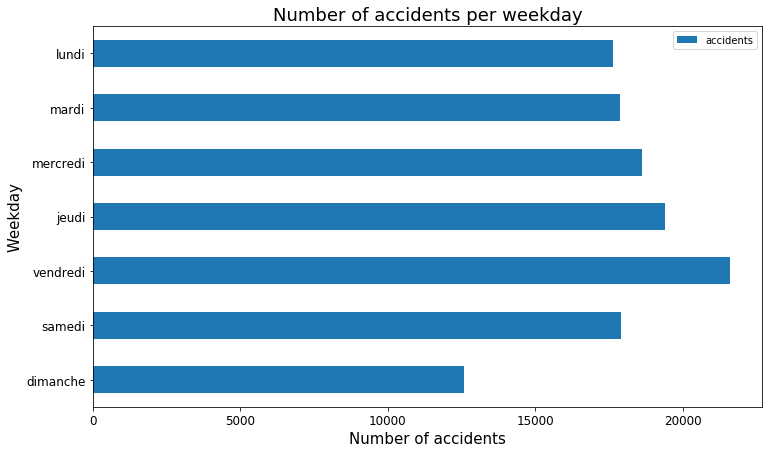

In [93]:
# Compute the number of accidents per weekday, rename the index and the columns
df_day = df_hacked_accident[['accidentday', 'id']].\
    groupby('accidentday')[['id']].count().\
    reindex(['lundi','mardi','mercredi','jeudi','vendredi','samedi','dimanche']).\
    rename(columns = {'id' : 'accidents'})

# Plot the results
plot_dataframe(x=df_day[::-1], title="Number of accidents per weekday",\
               xlabel='Number of accidents', ylabel='Weekday', bars='barh',name_save='accident_weekday')

In [114]:
[d[0] for d in df_day[::-1].values]

[12584, 17882, 21599, 19387, 18593, 17864, 17617]

In [117]:
plot([go.Bar(x=df_day[::-1].index.values, y=[d[0] for d in df_day[::-1].values])],filename='test_output/test.html')

'file://C:\\Users\\Clementg20\\OneDrive\\INSA _ Mes Cours\\EPFL\\Applied Data Analysis\\Git\\project-pizzafels\\Working Notebooks\\test_output\\test.html'

NameError: name 'traces' is not defined

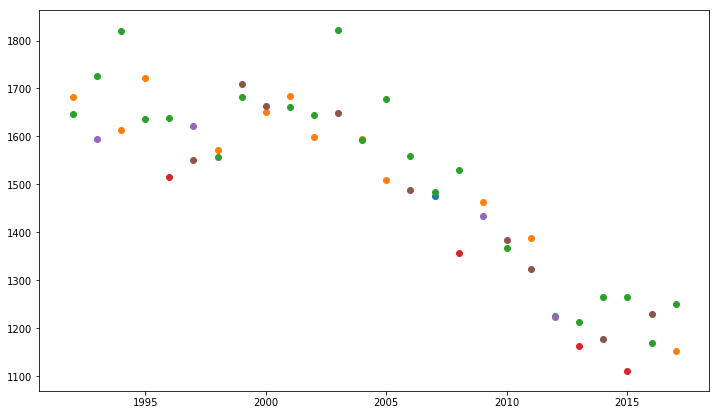

In [126]:
# Number of months to plot for each year
months_to_plot = 2

# Group by month and only keep the biggest values
monthly_basis = df_Accident_circonstances.groupby('mois_index').sum().\
        reset_index().apply(lambda x: x.nlargest(months_to_plot))
# Plot the results (we cannot use our function here)
plt.figure(figsize=(12,7))
for month in range(monthly_basis.shape[0]):
    to_plot = monthly_basis.iloc[month].values[6:]
    # Check if there is something to plot: this will control the labels and
    # not print the names of the months that don't appear in the plot
    if len(to_plot[np.isnan(to_plot)==False]) != 0:
        # Scatter plot, where the months indices are transformed to strings
        plt.scatter(np.arange(1992,2018,1), monthly_basis.iloc[month].values[6:],\
            label=datetime.date(1900, int(monthly_basis.index[month]+1), 1).strftime('%B'))
# Customization
plt.title('Accidents by month for the {} months with the most accidents each year'.\
          format(months_to_plot), fontsize=23)
plt.legend(fontsize=10, loc="best", bbox_to_anchor=(1,1))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Number of accidents', fontsize=15)
plt.savefig(PLOT_FOLDER+'accident_2months'+'.png')
plt.show()



In [25]:
# Plot the results (we cannot use our function here)
traces = []
for month in range(monthly_basis.shape[0]):
    to_plot = monthly_basis.iloc[month].values[6:]
    # Check if there is something to plot: this will control the labels and
    # not print the names of the months that don't appear in the plot
    if len(to_plot[np.isnan(to_plot)==False]) != 0:
        # Scatter plot, where the months indices are transformed to strings
        traces.append(go.Scatter(x=np.arange(1992,2018,1),y=monthly_basis.iloc[month].values[6:],name=datetime.date(1900, int(monthly_basis.index[month]+1), 1).strftime('%B'),mode = 'markers'))
# Customization
layout = go.Layout(
        title='Accidents by month for the {} months with the most accidents each year'.\
          format(months_to_plot),
        titlefont=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            ),
        xaxis=dict(
            title='Year',
            titlefont=dict(
                family='Courier New, monospace',
                size=15,
                color='#7f7f7f'
            )
        ),
        yaxis=dict(
            title='Number of accidents',
            titlefont=dict(
                family='Courier New, monospace',
                size=15,
                color='#7f7f7f'
            )
        )
    )
init_notebook_mode(connected=True)
fig = go.Figure(data=traces,layout=layout)
iplot(fig,filename='test_output/test.html')
plot(fig,filename='test.html',auto_open=False)

NameError: name 'monthly_basis' is not defined

In [23]:
df_display = df_conducteur.loc[[('Homme', '20 ans'), ('Homme', '18-19 ans'),
       ('Homme', '21-29 ans'), ('Femme', '20 ans'),
       ('Homme', '30-39 ans'), ('Femme', '21-29 ans'),
       ('Homme', '70 ans et plus'),
       ('Homme', '15-17 ans'), ('Homme', '10-14 ans'),
       ('Homme', '6-9 ans'), ('Femme', '10-14 ans'),
       ('Femme', '15-17 ans')],['1992', '2017']]

In [41]:
sample_data_table = FF.create_table(df_display.head(),index=True)

In [39]:
init_notebook_mode(connected=True)

In [40]:
iplot(sample_data_table)

In [47]:
df_frais_cantons_normalized = df_Frais_routes_cantonales.copy()

# Sum the different types of expenses (with the police surveillance) in a new column
df_frais_cantons_normalized['Expenses'] =\
    df_frais_cantons_normalized[['Constructions', 'Amélio-', 'Entretien Construction',\
                      'Entretien Exploitation']].sum(axis=1)

# Drop the now useless columns
df_frais_cantons_normalized =\
    df_frais_cantons_normalized[['annee', 'canton', 'Expenses']]

# Create a dataframe with the cantons in index and the years in columns
df_frais_cantons_normalized = df_frais_cantons_normalized.\
    pivot(index = 'canton', columns = 'annee', values = 'Expenses').\
    rename(columns = lambda x : str(x))

# Create a dataframe with the cantons in index and the years in columns for
# the road length
df_routes_cantons =\
    df_Longueur_routes.pivot(index = 'canton', columns='annee', values = 'Total').\
    rename(columns = lambda x : str(x))

# Normalization
for cant in df_frais_cantons_normalized.index.values:
    for year in df_frais_cantons_normalized.columns:
        df_frais_cantons_normalized.loc[cant][year] =\
                    df_frais_cantons_normalized.loc[cant][year]/\
                    df_routes_cantons.loc[cant][year]*100

KeyError: 'the label [St. Gall] is not in the [index]'

To analyze the correlations, we need to restrain ourselves to the period between 1994 and 2015, because of the lack of information.

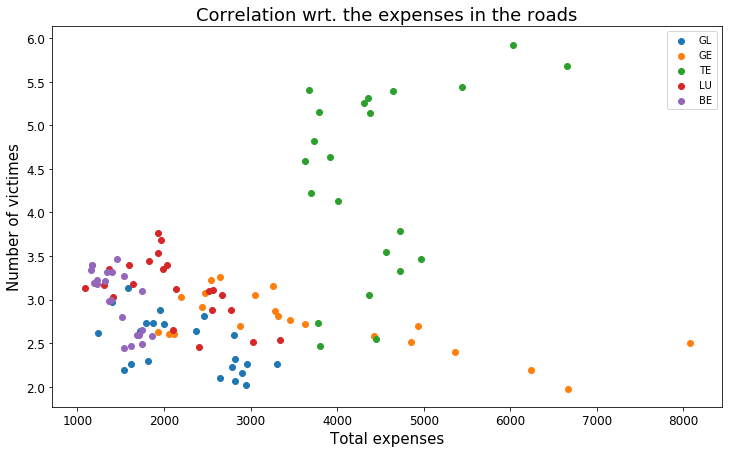

In [57]:
df_victimes_cantons_normalized_toplot = df_victimes_cantons_normalized.copy()

# Drop the uninteresting columns
df_victimes_cantons_normalized_toplot = df_victimes_cantons_normalized_toplot.\
    drop(columns = ['1992', '1993', '2016', '2017'])

# Order the dataframe wrt to 2015
df_victimes_cantons_normalized_toplot =\
    df_victimes_cantons_normalized_toplot.sort_values('2015', ascending = False)

# Order both dataframes to have a 1-1 correspondance between the rows
df_frais_cantons_normalized =\
    df_frais_cantons_normalized.reindex(df_victimes_cantons_normalized_toplot.index)

# Plot with our function
plot_correlation(x = df_frais_cantons_normalized[1:6], y = df_victimes_cantons_normalized_toplot[1:6],\
                title='Correlation wrt. the expenses in the roads', xlabel='Total expenses',\
                ylabel='Number of victimes', labels=df_frais_cantons_normalized.index[1:6],name_save='correlation_expenses_roads')